# Methodology

We follow a machine learning approach as exemplified in the original github.com package. Nonetheless, the initial experimentation was performed using time series algorithms as autoregressive integrated moving average (ARIMA) and autoregressive moving average (ARMA). However, the package used to create these models could not produce a model for each Country, and particular transformations were needed for each case to obtain a satisfactory ARIMA or ARMA model; given the amount of work, we decided to abandon this path and go straight to the approach described in the package examples, particular in the linear one. 

## Data transformation

The first step was to transform the data into the format required by most algorithms implemented in the scikit-learn package.

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
from EvoMSA import base
# NixtamalAI's packages
from covid_xprize.nixtamalai.helpers import ID_COLS, DEATHS_COL
from covid_xprize.nixtamalai import helpers
from covid_xprize.nixtamalai import models
from microtc.utils import save_model

In [2]:
_ = helpers.update_OxCGRT_tests()

In [3]:
# Getting de data
data = helpers.preprocess_full()            

In [4]:
data.Date.max()

Timestamp('2020-12-28 00:00:00')

In [4]:
population = {k:v for k, v in data.groupby("GeoID").Population.last().items()}

def predict(data, trans, model, start_date="2020-11-13", end_date="2020-12-05"):
    output = defaultdict(list)
    for X in trans.transform(data, start=start_date, end=end_date):
        hy = trans.update_prediction(model.predict(X))
        key = X.iloc[0]["GeoID"]
        output[key].append(hy)
    geo_pred_dfs = list()
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')    
    data = data[(data.Date >= start_date) & (data.Date <= end_date)].copy()
    for key, value in output.items():
        geo_pred_df = data.loc[data.GeoID == key, ID_COLS].copy()
        # print(len(value), geo_pred_df.shape, key)
        geo_pred_df['PredictedDailyNewCases'] = value[-geo_pred_df.shape[0]:]
        geo_pred_dfs.append(geo_pred_df)
    pred_df = pd.concat(geo_pred_dfs)
    return pred_df

def compute_y_hy(output):
    res = pd.merge(data, output, how="inner")
    _ = [((100000 * value.NewCasesHampel /  population[key]).rolling(7, min_periods=1).mean().to_numpy(),
          (100000 * value.PredictedDailyNewCases /  population[key]).rolling(7, min_periods=1).mean().to_numpy())
         for key, value in res.groupby("GeoID")]

    y = np.concatenate([x[0] for x in _])
    hy = np.concatenate([x[1] for x in _])
    return y, hy

def performance(output):
    res = pd.merge(data, output, how="inner")
    y = res.NewCasesHampel.rolling(7, min_periods=1).mean()
    hy = res.PredictedDailyNewCases.rolling(7, min_periods=1).mean()
    mae = metrics.mean_absolute_error(y, hy)

    _ = [((100000 * value.NewCasesHampel /  population[key]).rolling(7, min_periods=1).mean().to_numpy(),
          (100000 * value.PredictedDailyNewCases /  population[key]).rolling(7, min_periods=1).mean().to_numpy())
         for key, value in res.groupby("GeoID")]

    y = np.concatenate([x[0] for x in _])
    hy = np.concatenate([x[1] for x in _])
    return [mae, metrics.mean_absolute_error(y, hy)]

The dataset is a matrix of the exogenous variables and the number of cases, each using thirty lags. Regarding the number of cases, we observed two approaches: to use the raw number, and the other is to transform it into cases per 100,000 individuals. 

In [ ]:
# Number of cases
trans = models.Features(static_cols=[]).fit(data)
# Number of cases per 100000
transN = models.FeaturesN(static_cols=[]).fit(data)

In [ ]:
# Creating the models
HY = []
for t in [trans, transN]:
    X, y = t.training_set()
    m = models.AR().fit(X, y)
    _ = predict(data, t, m)
    HY.append(_)

In [ ]:
# Performance MAE [Number of cases, Number of cases per 100000]
for hy in HY:
    _ = performance(hy)
    print(["%0.4f" %x for x in _])

## Performance of the number of lags

In [ ]:
# Predictions when the number of lags are varied from:
lags = [2, 4, 8, 16, 32, 64]
HY = []
for lag in tqdm(lags):
    transN = models.FeaturesN(lags=lag, static_cols=[]).fit(data)
    X, y = transN.training_set()
    m = models.AR().fit(X, y)
    _ = predict(data, transN, m)
    HY.append(_)

In [ ]:
D = []
for hy in HY:
    D.append({k: v for k, v in zip(["MAE", "Norm. MAE"], performance(hy))})
perf = pd.DataFrame(D, index=lags)

In [ ]:
perf.loc[:, "Norm. MAE"].plot(grid=True)

In [ ]:
perf.loc[:, "MAE"].plot(grid=True)

## Comparison between using static variables or not

In [ ]:
transN = models.FeaturesN(lags=16, static_cols=[]).fit(data)
X, y = transN.training_set()
m = models.AR().fit(X, y)
_ = predict(data, transN, m)
print(X.shape)
performance(_)

In [22]:
data[data.Date > "2020-06-01"]

(46964, 36)

In [6]:
transN = models.FeaturesN(lags=16).fit(data)
X, y = transN.training_set()

In [12]:
m = models.AR().fit(X, y)
_ = predict(data, transN, m)
print(X.shape)
y1, hy = compute_y_hy(_)
ar = np.fabs(y1 - hy)
performance(_)

(71036, 226)


[1170.083430841281, 6.722204096218067]

## Comparison of different models

In [18]:
# Lars
m = models.Lars().fit(X, y)
_ = predict(data, transN, m)
y1, hy = compute_y_hy(_)
lars = np.fabs(y1 - hy)
performance(_)

[1125.9026689109628, 6.834474244851844]

In [8]:
# Lasso
m = models.Lasso().fit(X, y)
_ = predict(data, transN, m)
y1, hy = compute_y_hy(_)
lasso = np.fabs(y1 - hy)
performance(_)

[1151.485254030404, 7.304837797011862]

In [9]:
# RandomForest
m = models.RandomForest().fit(X, y)
_ = predict(data, transN, m)
y1, hy = compute_y_hy(_)
random_forest = np.fabs(y1 - hy)
performance(_)

[913.5566971160629, 7.1892394143444385]

In [10]:
# ExtraTrees
m = models.ExtraTrees().fit(X, y)
_ = predict(data, transN, m)
y1, hy = compute_y_hy(_)
extra_trees = np.fabs(y1 - hy)
performance(_)

[1013.371795876879, 7.097148449156995]

In [11]:
# EvoMSA
# transN = models.FeaturesN(lags=16, date="2020-12-21").fit(data)
transN = models.FeaturesN(lags=16).fit(data)
X, y = transN.training_set()
evo = base.EvoMSA(TR=False, stacked_method=models.AR,
                  classifier=False, n_jobs=1, tm_n_jobs=1,
                  models=[[models.Identity, models.AR],
                          [models.Identity, models.Lars],
                          [models.Identity, models.Lasso]]).fit(X, y)
# save_model([transN, evo], "evomsaN.model")                          
_ = predict(data, transN, evo)
y1, hy = compute_y_hy(_)
evomsa = np.fabs(y1 - hy)
performance(_)                           

00, 3089.35it/s]
100%|██████████| 3/3 [00:00<00:00, 1885.65it/s]


[1119.0310118026011, 6.658536613282985]

In [13]:
from microtc.utils import save_model
save_model([ar, lars, lasso, random_forest, extra_trees, evomsa], "bbox-models.pickle.gz")

In [5]:
transN = models.FeaturesN(lags=16, static_cols=[]).fit(data)
X, y = transN.training_set()
evo = base.EvoMSA(TR=False, stacked_method=models.AR,
                  classifier=False, n_jobs=1, tm_n_jobs=1,
                  models=[[models.Identity, models.AR],
                          [models.Identity, models.Lars],
                          [models.Identity, models.Lasso]]).fit(X, y)
# save_model([transN, evo], "evomsaN.model")                          
_ = predict(data, transN, evo)
y1, hy = compute_y_hy(_)
evomsa_st_cols = np.fabs(y1 - hy)
performance(_)

t/s]
100%|██████████| 3/3 [00:00<00:00, 5320.47it/s]


[1234.5163888186203, 6.846834894304565]

In [6]:
from microtc.utils import save_model, load_model
ar, lars, lasso, random_forest, extra_trees, evomsa = load_model("bbox-models.pickle.gz")
save_model([ar, lars, lasso, random_forest, extra_trees, evomsa, evomsa_st_cols], "bbox-models.pickle.gz")



In [8]:
transN._data.Date.max()

Timestamp('2020-12-21 00:00:00')

Populating the interactive namespace from numpy and matplotlib


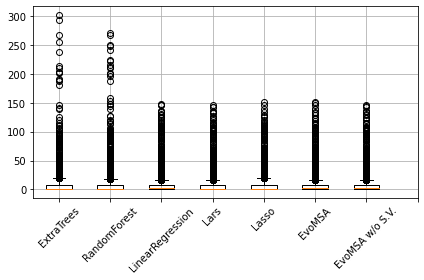

In [14]:
%pylab inline
from matplotlib import pylab as plt
plt.grid()
_ = boxplot([extra_trees, random_forest, ar, lars, lasso, evomsa, evomsa_st_cols])
plt.xticks(np.arange(1, 9), ["ExtraTrees", "RandomForest", "LinearRegression", "Lars", "Lasso", "EvoMSA", "EvoMSA w/o S.V."], rotation=45)
plt.tight_layout()
plt.savefig("boxplot.png")

Populating the interactive namespace from numpy and matplotlib


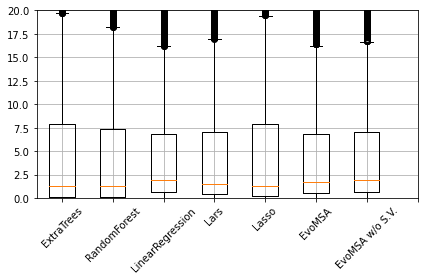

In [15]:
%pylab inline
from matplotlib import pylab as plt
plt.grid()
plt.ylim(0, 20)
_ = boxplot([extra_trees, random_forest, ar, lars, lasso, evomsa, evomsa_st_cols])
plt.xticks(np.arange(1, 9), ["ExtraTrees", "RandomForest", "LinearRegression", "Lars", "Lasso", "EvoMSA", "EvoMSA w/o S.V."], rotation=45)
plt.tight_layout()
plt.savefig("boxplot-zoom.png")

In [13]:
[np.mean(x) for x in [ar, lars, lasso, random_forest, extra_trees, evomsa, evomsa_st_cols]]

[6.722204096218067,
 6.721088639240359,
 7.304837797011862,
 7.1892394143444385,
 7.097148449156995,
 6.658536613282985,
 6.846834894304565]

# Deaths

In [9]:
from microtc.utils import save_model
transN = models.FeaturesN(lags=16, cases_col=DEATHS_COL, date="2020-12-21").fit(data)
X, y = transN.training_set()
evo = base.EvoMSA(TR=False, stacked_method=models.AR,
                  classifier=False,
                  models=[[models.Identity, models.AR],
                          [models.Identity, models.Lars],
                          [models.Identity, models.Lasso]]).fit(X, y)
save_model([transN, evo], "evomsaD.model")

100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


# Stats

In [8]:
transN = models.FeaturesN(lags=16).fit(data)
X, y = transN.training_set()

Populating the interactive namespace from numpy and matplotlib


(array([6.8004e+04, 2.5970e+03, 2.6200e+02, 9.0000e+01, 3.3000e+01,
        1.9000e+01, 1.3000e+01, 1.1000e+01, 6.0000e+00, 1.0000e+00]),
 array([-26.29118953,  26.6710888 ,  79.63336713, 132.59564547,
        185.5579238 , 238.52020213, 291.48248046, 344.4447588 ,
        397.40703713, 450.36931546, 503.3315938 ]),
 <a list of 10 Patch objects>)

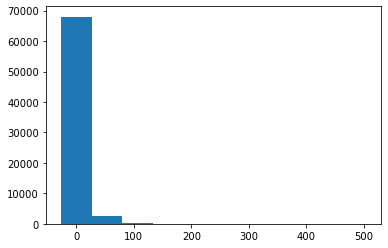

In [16]:
%pylab inline
hist(y)

In [11]:
from scipy.stats import describe

In [12]:
describe(y)

DescribeResult(nobs=71036, minmax=(-26.29118953026408, 503.3315937951429), mean=5.202859699876416, variance=237.99874929700698, skewness=10.449196078106102, kurtosis=183.01184393843297)

In [13]:
np.sqrt(237) * 3

46.184412955021955

In [17]:
transN = models.FeaturesN(lags=16, cases_col=DEATHS_COL).fit(data)
X, y = transN.training_set()

In [18]:
describe(y)

DescribeResult(nobs=71036, minmax=(-0.33003300330033003, 11.684973124561813), mean=0.09386558587800263, variance=0.10636324221457095, skewness=10.965567246817406, kurtosis=190.26288220811085)

In [16]:
X.shape

(71036, 209)

In [17]:
210 * 3

630